In [2]:
#!/usr/bin/env python
# coding: utf-8
'''
construct model for points cloud input based on XG-Boost
'''

import sys
root_dir = '../../'
sys.path.append(root_dir)
sys.path.append(root_dir + 'Data/corner/scripts')

import os
import psutil
import matplotlib
# matplotlib.use('agg') # so that plt works in command line
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import Data_Feeder as feeder
import Metric_Recorder as recorder
import Model_Constructer as constructer

from optparse import OptionParser

In [17]:
data_path = root_dir + 'Data/corner/dw_19991231_162610_0.000000_0.000000/'
class_num = 2
line_re = '\t (?!3).*' # only corner radar
select_cols = [3,4,6,7] # all cols

dataset = feeder.Corner_Radar_Points_Gen_Feeder(data_path, 
                                                class_num=class_num, 
                                                use_onehot=False, 
                                                line_re=line_re, 
                                                select_cols=select_cols)
points, labels = dataset.get_all_data(allowed=True)
points = np.vstack(points)
labels = np.concatenate(labels)

print(dataset.feature_names)

['y', 'angle', 'speed', 'rcs']


In [11]:
dtrain = xgb.DMatrix(points[100000:], label=labels[100000:], feature_names=dataset.feature_names)
dval = xgb.DMatrix(points[:100000], label=labels[:100000], feature_names=dataset.feature_names)

In [28]:
print(points.shape)
(np.logical_and(points[:,-1] > -18, points[:,1] < 2.9)).sum()

(698782, 4)


628153

In [12]:
param = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',# 'multi:softmax' for multi-class
#     'gamma': 0.1,                  # if post-pruning, the larger the more conservative (usually 0.1, 0.2)
#     'max_depth': 12,               # depth of tree, the larger the easier to overfit
#     'lambda': 2,                   # for L2 normalization
#     'subsample': 0.7,              # random sample for training
#     'colsample_bytree': 0.7,       # subsample in cols when generating the tree
    'silent': 1,                   # if silent (0 for verbose)
#     'eta': 0.007,                  # learning rate
    'nthread': 8,                  # cpu threads
    'eval_metric': ['error', 'auc', 'aucpr', 'map']
}
evallist = [(dval, 'eval'), (dtrain, 'train')]

In [13]:
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist)
# 3467 [99]	eval-error:0.01859	eval-auc:0.993898	eval-aucpr:0.886296	eval-map:0.886315	train-error:0.01229	train-auc:0.996885	train-aucpr:0.930976	train-map:0.930977
# 346       eval-error:0.01861	eval-auc:0.993574	eval-aucpr:0.88038	eval-map:0.880391	train-error:0.012836	train-auc:0.996506	train-aucpr:0.922858	train-map:0.922861

[0]	eval-error:0.02415	eval-auc:0.975698	eval-aucpr:0.704978	eval-map:0.715066	train-error:0.020819	train-auc:0.98167	train-aucpr:0.717417	train-map:0.721453
[1]	eval-error:0.0238	eval-auc:0.983227	eval-aucpr:0.716463	eval-map:0.724422	train-error:0.02059	train-auc:0.987588	train-aucpr:0.728184	train-map:0.734173
[2]	eval-error:0.02344	eval-auc:0.984951	eval-aucpr:0.783668	eval-map:0.784998	train-error:0.019794	train-auc:0.989221	train-aucpr:0.807092	train-map:0.807168
[3]	eval-error:0.02327	eval-auc:0.985982	eval-aucpr:0.793963	eval-map:0.79621	train-error:0.019237	train-auc:0.990321	train-aucpr:0.816909	train-map:0.815699
[4]	eval-error:0.0217	eval-auc:0.986857	eval-aucpr:0.823932	eval-map:0.824753	train-error:0.018199	train-auc:0.990812	train-aucpr:0.831612	train-map:0.831023
[5]	eval-error:0.02297	eval-auc:0.98736	eval-aucpr:0.824752	eval-map:0.823166	train-error:0.018967	train-auc:0.991135	train-aucpr:0.834049	train-map:0.833638
[6]	eval-error:0.02179	eval-auc:0.987556	eval-aucpr:

[52]	eval-error:0.01878	eval-auc:0.993136	eval-aucpr:0.874098	eval-map:0.874123	train-error:0.014904	train-auc:0.995566	train-aucpr:0.905033	train-map:0.905037
[53]	eval-error:0.01878	eval-auc:0.993128	eval-aucpr:0.874073	eval-map:0.874087	train-error:0.014902	train-auc:0.995573	train-aucpr:0.905105	train-map:0.905107
[54]	eval-error:0.01879	eval-auc:0.993129	eval-aucpr:0.874115	eval-map:0.874135	train-error:0.014879	train-auc:0.995578	train-aucpr:0.905175	train-map:0.905178
[55]	eval-error:0.01881	eval-auc:0.993134	eval-aucpr:0.874178	eval-map:0.87419	train-error:0.014838	train-auc:0.995599	train-aucpr:0.905492	train-map:0.905496
[56]	eval-error:0.01893	eval-auc:0.99316	eval-aucpr:0.875327	eval-map:0.875337	train-error:0.014695	train-auc:0.995638	train-aucpr:0.906536	train-map:0.906539
[57]	eval-error:0.01894	eval-auc:0.993218	eval-aucpr:0.876089	eval-map:0.876109	train-error:0.014488	train-auc:0.99572	train-aucpr:0.907937	train-map:0.907938
[58]	eval-error:0.01896	eval-auc:0.993227	e

In [7]:
save_dir = './Model/'
model_name = 'xgb'
bst.dump_model('xgb.txt')

[3, 4, 6] 
 ['y', 'angle', 'speed']


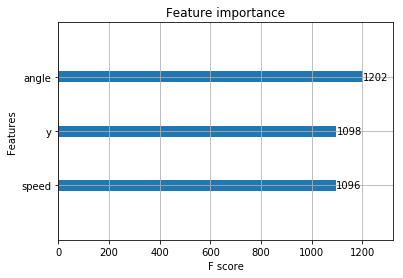

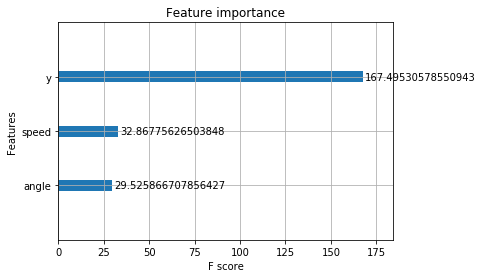

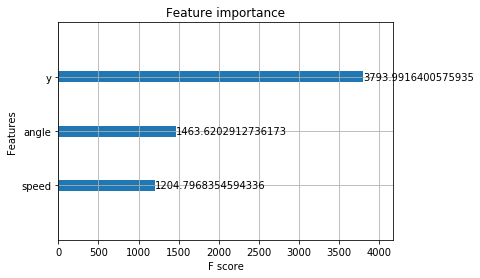

In [14]:
for importance_type in ['weight', 'gain', 'cover']:
    xgb.plot_importance(bst, importance_type=importance_type)
print(select_cols, '\n', dataset.feature_names)

[3, 4, 6, 7] 
 ['y', 'angle', 'speed', 'rcs']


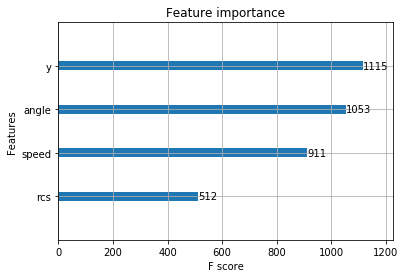

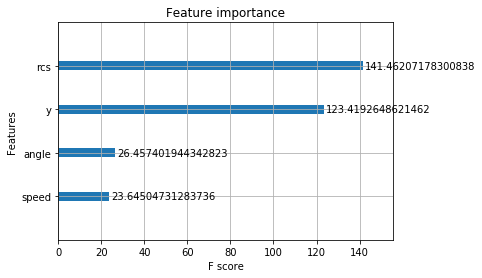

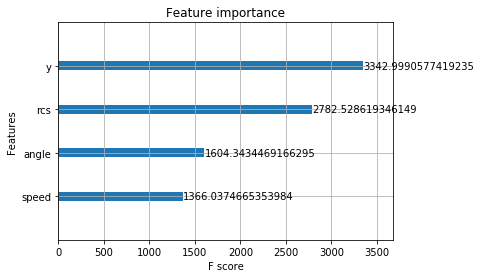

In [8]:
for importance_type in ['weight', 'gain', 'cover']:
    xgb.plot_importance(bst, importance_type=importance_type)
print(select_cols, '\n', dataset.feature_names)

In [15]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(300,300))
xgb.plot_tree(bst, ax=ax)
fig.savefig('346.png', bbox_inches='tight')
plt.close()

In [ ]:
for i, feat in enumerate(['1', '2', '234', '456']):
        print('{0}\t{1}\tq\n'.format(i, feat))

In [ ]:
feat_importances = []
for ft, score in bst.get_fscore().iteritems():
    feat_importances.append({'Feature': ft, 'Importance': score})

In [ ]:
bst.get_fscore()